In [12]:
#install libraries
# Sitzung muss neu gestartet werden und dann muss die zelle neu ausgeführt werden.
#!pip install pandas
#!pip install pycaret[full]  # [full] für alle Abhängigkeiten, zB dashborad
#!pip install explainerdashboard
#import libraries
import pandas as pd
print(f"pandas version: {pd.__version__}")
_ = pd.set_option('display.max_columns', None) # damit mehr als 20 Spalten angezeigt werden.
pd.set_option('display.min_rows', 8) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
pd.set_option('display.max_rows', 12) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden

#import explainerdashboard as ed
from pycaret.regression import *

# workaround für manchmal verschwindende Anzeige von Zellen in Standard Jupyter (nicht in Jupyterlab), Stand 07/2025
from IPython.display import display, HTML

display(HTML("""
<style>
div.output_scroll {
    overflow-y: auto;
    max-height: 500px;
}
</style>
"""))


pandas version: 2.1.4


In [2]:
#read data from local drive
df_org = pd.read_csv("AmesHousing.csv")

df_org.info()
df_org.describe()
# Name eines Datensatzes für interaktive Anzeigen konkatenieren.
df_org['Name'] = ( df_org['Order'].astype(str) + ' ' + df_org['SalePrice'].astype(str) + ' ' + df_org['Neighborhood'].astype(str) + 
      ' ' + df_org['Gr Liv Area'].astype(str) )
df_org.index = df_org.Name
df_org.index.name = "Housesale"
_= df_org.reindex(df_org.index)
df_org.drop(['Name'],axis=1,inplace=True) # ist als index umgeschrieb. orginales feld als type object stört.
df_org.info()

#Datenaufbereitung nach den wichtigen Datenqualitätsdimensionen (nicht nach Themen der Variablen)

df=df_org.copy()
#Fehlende Daten (DQ Vollständigkeit)
#     oder df.replace('', np.nan, inplace=True)

df['Lot Frontage'] = df['Lot Frontage'].fillna(df['Lot Frontage'].mean())
df['BsmtFin SF 1'] = df['BsmtFin SF 1'].fillna(0)
df['BsmtFin SF 2'] = df['BsmtFin SF 2'].fillna(0)
df['Bsmt Unf SF'] = df['Bsmt Unf SF'].fillna(0)
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)
df['Total Bsmt SF'] = df['Total Bsmt SF'].fillna(0)
df['Bsmt Unf SF'] = df['Bsmt Unf SF'].fillna(0)
df['Bsmt Full Bath'] = df['Bsmt Full Bath'].fillna(0)
df['Bsmt Half Bath'] = df['Bsmt Half Bath'].fillna(0)
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(df['Year Built'])
df['Garage Cars'] = df['Garage Cars'].fillna(0)
df['Garage Area'] = df['Garage Area'].fillna(0)


#fehlerhafte Daten oder Ausreisser (DQ Korrektheit)
df.drop(index=df.loc[df.loc[:,'Gr Liv Area'] > 4000].index, inplace=True) #3 Datensätze nach Original Dokumentation
df.loc[df['Order'] ==2261, 'Garage Yr Blt'] = 2007 # Datenfehler, da zuvor 2207
df = df.loc[~((df['Sale Condition'] == 'Abnorml') | (df['Sale Condition'] == 'Family') )] # Abnorml     189, Family       46, Partial     242

#ordinale Variablen numerisch machen (DQ Bearbeitbarkeit)
df['Lot Shape'] = df['Lot Shape'].map({'Reg':3,'IR1':2,'IR2':1,'IR3':0})
df['Land Slope'] = df['Land Slope'].map({'Gtl':3,'Mod':2,'Sev':0})
df['Land Contour'] = df['Land Contour'].map({'Lvl':3,'Bnk':2,'HLS':1,'Low':0})
df['Lot Config'] = df['Lot Config'].map({'CulDSac':4, 'Inside':3,'Corner':2,'FR2':1,'FR3':1})
df['Paved Drive'] = df['Paved Drive'].map({'N':0,'P':1,'Y':2}) # None, Partial, Yes
df['MS Zoning'] = df['MS Zoning'].map({'RP':8,'RL':7,'RM':6,'RH':5,'FV':4,'FV':3,'C (all)':2,'A (agr)':2,'I (all)':0})

df.loc[df['Condition 1'] == 'RRAn', 'Railroad_Adjacent'] = 1
df.loc[df['Condition 2'] == 'RRAn', 'Railroad_Adjacent'] = 1
df.loc[df['Condition 1'] == 'RRAe', 'Railroad_Adjacent'] = 1
df.loc[df['Condition 2'] == 'RRAe', 'Railroad_Adjacent'] = 1
df['Railroad_Adjacent'] = df['Railroad_Adjacent'].fillna(0)
df.loc[df['Condition 1'] == 'RRNn', 'Railroad_Near'] = 1
df.loc[df['Condition 2'] == 'RRNn', 'Railroad_Near'] = 1
df.loc[df['Condition 1'] == 'RRNe', 'Railroad_Near'] = 1
df.loc[df['Condition 2'] == 'RRNe', 'Railroad_Near'] = 1
df['Railroad_Near'] = df['Railroad_Near'].fillna(0)
df.loc[df['Condition 1'] == 'Feedr', 'Street_Feeder'] = 1
df.loc[df['Condition 2'] == 'Feedr', 'Street_Feeder'] = 1
df['Street_Feeder'] = df['Street_Feeder'].fillna(0)
df.loc[df['Condition 1'] == 'Artery', 'Street_Aterial'] = 1
df.loc[df['Condition 2'] == 'Artery', 'Street_Aterial'] = 1
df['Street_Aterial'] = df['Street_Aterial'].fillna(0)
df.loc[df['Condition 1'] == 'PosA', 'PosFeature_Adjacent'] = 1
df.loc[df['Condition 2'] == 'PosA', 'PosFeature_Adjacent'] = 1
df['PosFeature_Adjacent'] = df['PosFeature_Adjacent'].fillna(0)
df.loc[df['Condition 1'] == 'PosN', 'PosFeature_Near'] = 1
df.loc[df['Condition 2'] == 'PosN', 'PosFeature_Near'] = 1
df['PosFeature_Near'] = df['PosFeature_Near'].fillna(0)
df.drop(['Condition 1', 'Condition 2'],axis=1,inplace=True)
df['Alley'] = df['Alley'].fillna('NA') 
df['Alley'] = df['Alley'].map({'Pave':3,'Grvl':2,'NA':0})
df['Bsmt Qual'] = df['Bsmt Qual'].map({'Ex':4,'Gd':3,'TA':2.5,'Fa':2,'Po':1.5,'None':0})
df['Bsmt Qual'] = df['Bsmt Qual'].fillna(0)
df['Bsmt Cond'] = df['Bsmt Cond'].map({'Ex':4,'Gd':3,'TA':2.5,'Fa':2,'Po':1.5,'None':0})
df['Bsmt Cond'] = df['Bsmt Cond'].fillna(0)
df['Electrical'] = df['Electrical'].map({'SBrkr':4,'FuseA':3,'FuseF':2, 'FuseP':1, 'Mix':0})
df['Electrical'] = df['Electrical'].fillna(0)
df['Heating QC'] = df['Heating QC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
df['Central Air'] = df['Central Air'].map({'Y':1,'N':0})
df['Fireplace Qu'] = df['Fireplace Qu'].fillna('None')
df['Fireplace Qu'] = df['Fireplace Qu'].map({'Ex':4,'Gd':3,'TA':2.5,'Fa':2,'Po':1.5,'None':0,'NA':0})
df['Pool QC'] = df['Pool QC'].fillna('None')
df['Pool QC'] = df['Pool QC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0,'NA':0})
df['Fence'] = df['Fence'].fillna('None')
df['Fence'] = df['Fence'].map({'GdPrv':4,'GdWo':3,'MnPrv':2,'MnWw':1,'None':0,'NA':0})
for i in ['Exter Qual','Exter Cond','Kitchen Qual']:
    df[i] = df[i].map({'Ex':4,'Gd':1,'TA':0,'Fa':-1,'Po':-4})
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map({'GLQ':4,'ALQ':3.5,'BLQ':3,'Rec':2,'LwQ':2,'Unf':1,'None':0})
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map({'GLQ':4,'ALQ':3.5,'BLQ':3,'Rec':2,'LwQ':2,'Unf':1,'None':0})
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].fillna(0)
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].fillna(0)
df['Bsmt Exposure'] = df['Bsmt Exposure'].map({'Gd':3,'Av':2,'Mn':1,'No':0,'None':0})
df['Bsmt Exposure'] = df['Bsmt Exposure'].fillna(0)
df['Utilities'] = df['Utilities'].map({'AllPub':4,'NoSewr':3,'NoSeWa':2,'ELO':1})
df['Garage Finish'] = df['Garage Finish'].fillna('None')
#df.loc[df['Garage Finish'] =="", 'Garage Finish'] = 0
df['Garage Finish'] = df['Garage Finish'].map({'Fin':3,'RFn':2,'Unf':1,'None':0,'NA':0,'0':0})
df['Garage Qual'] = df['Garage Qual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
df['Garage Qual'] = df['Garage Qual'].fillna(0)
df['Garage Cond'] = df['Garage Cond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
df['Garage Cond'] = df['Garage Cond'].fillna(0)
df['Functional'] = df['Functional'].map({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0})

df.loc[df['Exterior 1st'] == 'AsbShng', 'Exterior_AsbShng'] = 1
df.loc[df['Exterior 2nd'] == 'AsbShng', 'Exterior_AsbShng'] = 1
df['Exterior_AsbShng'] = df['Exterior_AsbShng'].fillna(0)
df.loc[df['Exterior 1st'] == 'BrkComm', 'Exterior_BrkComm'] = 1
df.loc[df['Exterior 2nd'] == 'BrkComm', 'Exterior_BrkComm'] = 1
df['Exterior_BrkComm'] = df['Exterior_BrkComm'].fillna(0)
df.loc[df['Exterior 1st'] == 'BrkFace', 'Exterior_BrkFace'] = 1
df.loc[df['Exterior 2nd'] == 'BrkFace', 'Exterior_BrkFace'] = 1
df['Exterior_BrkFace'] = df['Exterior_BrkFace'].fillna(0)
df.loc[df['Exterior 1st'] == 'CBlock', 'Exterior_CBlock'] = 1
df.loc[df['Exterior 2nd'] == 'CBlock', 'Exterior_CBlock'] = 1
df['Exterior_CBlock'] = df['Exterior_CBlock'].fillna(0)
df.loc[df['Exterior 1st'] == 'CemntBd', 'Exterior_CemntBd'] = 1
df.loc[df['Exterior 2nd'] == 'CemntBd', 'Exterior_CemntBd'] = 1
df['Exterior_CemntBd'] = df['Exterior_CemntBd'].fillna(0)
df.loc[df['Exterior 1st'] == 'HdBoard', 'Exterior_HdBoard'] = 1
df.loc[df['Exterior 2nd'] == 'HdBoard', 'Exterior_HdBoard'] = 1
df['Exterior_HdBoard'] = df['Exterior_HdBoard'].fillna(0)
df.loc[df['Exterior 1st'] == 'ImStucc', 'Exterior_ImStucc'] = 1
df.loc[df['Exterior 2nd'] == 'ImStucc', 'Exterior_ImStucc'] = 1
df['Exterior_ImStucc'] = df['Exterior_ImStucc'].fillna(0)
df.loc[df['Exterior 1st'] == 'MetalSd', 'Exterior_MetalSd'] = 1
df.loc[df['Exterior 2nd'] == 'MetalSd', 'Exterior_MetalSd'] = 1
df['Exterior_MetalSd'] = df['Exterior_MetalSd'].fillna(0)
df.loc[df['Exterior 1st'] == 'Plywood', 'Exterior_Plywood'] = 1
df.loc[df['Exterior 2nd'] == 'Plywood', 'Exterior_Plywood'] = 1
df['Exterior_Plywood'] = df['Exterior_Plywood'].fillna(0)
df.loc[df['Exterior 1st'] == 'PreCast', 'Exterior_PreCast'] = 1
df.loc[df['Exterior 2nd'] == 'PreCast', 'Exterior_PreCast'] = 1
df['Exterior_PreCast'] = df['Exterior_PreCast'].fillna(0)
df.loc[df['Exterior 1st'] == 'Stone', 'Exterior_Stone'] = 1
df.loc[df['Exterior 2nd'] == 'Stone', 'Exterior_Stone'] = 1
df['Exterior_Stone'] = df['Exterior_Stone'].fillna(0)
df.loc[df['Exterior 1st'] == 'Stucco', 'Exterior_Stucco'] = 1
df.loc[df['Exterior 2nd'] == 'Stucco', 'Exterior_Stucco'] = 1
df['Exterior_Stucco'] = df['Exterior_Stucco'].fillna(0)
df.loc[df['Exterior 1st'] == 'VinylSd', 'Exterior_VinylSd'] = 1
df.loc[df['Exterior 2nd'] == 'VinylSd', 'Exterior_VinylSd'] = 1
df['Exterior_VinylSd'] = df['Exterior_VinylSd'].fillna(0)
df.loc[df['Exterior 1st'] == 'Wd Sdng', 'Exterior_Wd Sdng'] = 1
df.loc[df['Exterior 2nd'] == 'Wd Sdng', 'Exterior_Wd Sdng'] = 1
df['Exterior_Wd Sdng'] = df['Exterior_Wd Sdng'].fillna(0)
df.loc[df['Exterior 1st'] == 'WdShing', 'Exterior_WdShing'] = 1
df.loc[df['Exterior 2nd'] == 'WdShing', 'Exterior_WdShing'] = 1
df['Exterior_WdShing'] = df['Exterior_WdShing'].fillna(0)
df.drop(['Exterior 1st', 'Exterior 2nd'],axis=1,inplace=True) # 



#one hot encoding (DQ Bearbeitbarkeit)
df = pd.get_dummies(df, columns=['Street','Neighborhood'], drop_first=True)
df = pd.get_dummies(df, columns=['House Style', 'Bldg Type', 'Foundation'], drop_first=True)
df['Misc Feature'] = df['Misc Feature'].fillna('None')
df = pd.get_dummies(df, columns=['Misc Feature'], drop_first=True)
df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna('None')
df = pd.get_dummies(df, columns=['Mas Vnr Type'], drop_first=True)
df = pd.get_dummies(df, columns=['Roof Matl', 'Roof Style'], drop_first=True)
df = pd.get_dummies(df, columns=['Heating'], drop_first=True)
df['Garage Type'] = df['Garage Type'].fillna('None')
df = pd.get_dummies(df, columns=['Garage Type'], drop_first=True)
df = pd.get_dummies(df, columns=['Sale Condition','Sale Type'], drop_first=True)

#Redundante, korrelierte oder assozierte Varablen entfernen
df.drop(['Order'],axis=1,inplace=True) # laufender Schlüssel
df.drop(['PID'],axis=1,inplace=True) # unnötige Geocodierung der Paketpost
df.drop(['Pool QC'],axis=1,inplace=True) # nur 7 bekannte Werte von 2930

#Data leakage
df.drop(['Mo Sold', 'Yr Sold'],axis=1,inplace=True) # Data Leakage. Könnte für Datenfehlererkennung benutzt werden.


# DQ Bearbeitbarkeit
#Datentyp bool numerisch machen 
for column in df.columns:
   if df[column].dtype == 'bool':
      df[column] = df[column].astype(int)
#
df.columns = df.columns.str.replace('.', '_') # sonst im Explainer InvalidComponentIdError: House Style_2.5Fin-input-db6` contains `.`


# Prüfen auf Erfolg
anzahl_nan_zeilen = df.isnull().any(axis=1).sum()
print(f"Anzahl der Zeilen mit mindestens einem NaN-Wert: {anzahl_nan_zeilen}\n")
pd.DataFrame(df.isnull().sum(), columns=['missing_value_count'])
df.info(verbose=True,show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [3]:
# help(setup)


In [3]:
#pyc_setup = setup(df_org, target = 'SalePrice', session_id = 42)  preprocess = False
pyc_setup = setup(df, target = 'SalePrice', session_id = 42, experiment_name = 'Ames Haousing Originaldaten',
                 preprocess = False)
#      , use_gpu=True führt zu [LightGBM] [Warning]
#      , log_experiment='mlflow', experiment_name='insurance_experiment'
bestModell = compare_models(sort = 'rmse')
compare_tree_models_results = pull()
compare_tree_models_results 

,Description,Value
0,Session id,42
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(2690, 166)"
4,Transformed data shape,"(2690, 166)"
5,Transformed train set shape,"(1882, 166)"
6,Transformed test set shape,"(808, 166)"
7,Numeric features,165


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,14063.4260,435906856.3350,20827.8650,0.9256,0.1061,0.0785,0.2130
lightgbm,Light Gradient Boosting Machine,13703.2446,470339093.9030,21582.6825,0.9197,0.1045,0.0751,0.2310
et,Extra Trees Regressor,14499.2858,500301808.3259,22257.1232,0.9156,0.1140,0.0822,0.5590
br,Bayesian Ridge,15287.8955,508969790.8120,22391.9426,0.9136,0.1322,0.0892,0.0260
ridge,Ridge Regression,15410.7366,517809070.1927,22594.6707,0.9118,0.1349,0.0899,0.0230
lasso,Lasso Regression,15552.6914,528241201.5860,22818.8760,0.9099,0.1406,0.0908,0.3840
lr,Linear Regression,15579.5920,529282198.6931,22841.1331,0.9097,0.1415,0.0910,0.5180
llar,Lasso Least Angle Regression,15772.1690,540629737.8292,23093.8429,0.9080,0.1369,0.0917,0.0280
rf,Random Forest Regressor,15127.0358,547980630.4542,23323.5696,0.9072,0.1183,0.0853,0.5830
en,Elastic Net,16883.6472,613676202.4056,24619.0621,0.8966,0.1450,0.0978,0.0870


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1.406343e+04,4.359069e+08,2.082787e+04,9.256000e-01,0.1061,0.0785,0.213
lightgbm,Light Gradient Boosting Machine,1.370324e+04,4.703391e+08,2.158268e+04,9.197000e-01,0.1045,0.0751,0.231
et,Extra Trees Regressor,1.449929e+04,5.003018e+08,2.225712e+04,9.156000e-01,0.1140,0.0822,0.559
br,Bayesian Ridge,1.528790e+04,5.089698e+08,2.239194e+04,9.136000e-01,0.1322,0.0892,0.026
ridge,Ridge Regression,1.541074e+04,5.178091e+08,2.259467e+04,9.118000e-01,0.1349,0.0899,0.023
lasso,Lasso Regression,1.555269e+04,5.282412e+08,2.281888e+04,9.099000e-01,0.1406,0.0908,0.384
lr,Linear Regression,1.557959e+04,5.292822e+08,2.284113e+04,9.097000e-01,0.1415,0.0910,0.518
llar,Lasso Least Angle Regression,1.577217e+04,5.406297e+08,2.309384e+04,9.080000e-01,0.1369,0.0917,0.028
rf,Random Forest Regressor,1.512704e+04,5.479806e+08,2.332357e+04,9.072000e-01,0.1183,0.0853,0.583
en,Elastic Net,1.688365e+04,6.136762e+08,2.461906e+04,8.966000e-01,0.1450,0.0978,0.087


In [5]:
# zeigt Auswertung zum besten Modell. nach Klick auf eine Menüoption dauert es bis zu einigen Minuten. Warten auf Ausgabe!

# Feature Selection funktioniert nicht oder dauert zu lang.

evaluate_model(bestModell)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

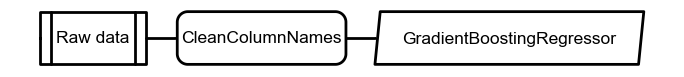

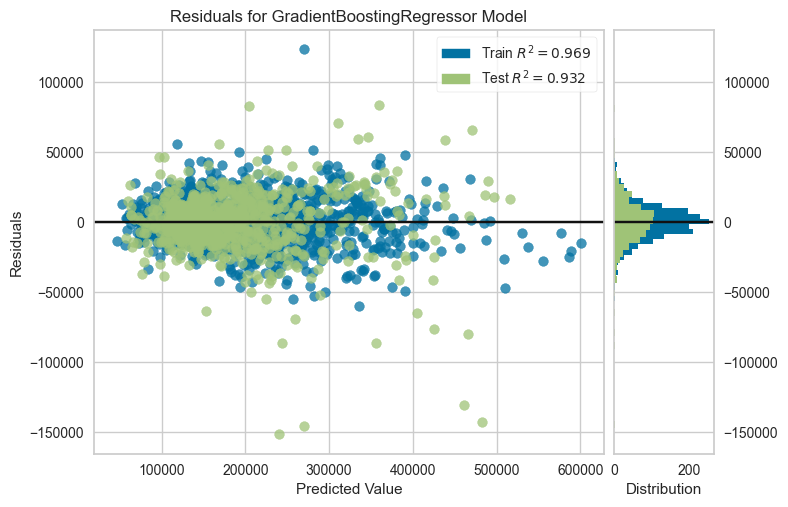

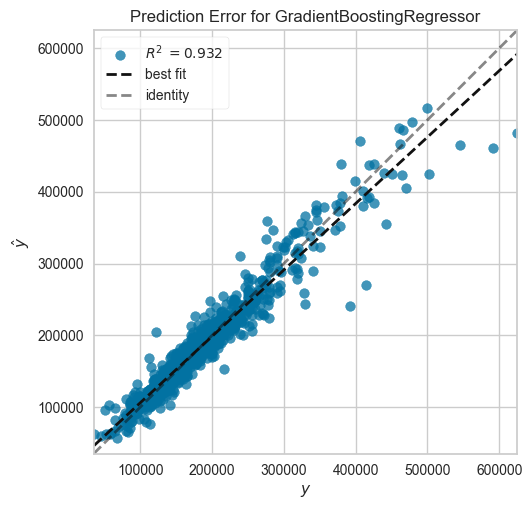

KeyboardInterrupt: 

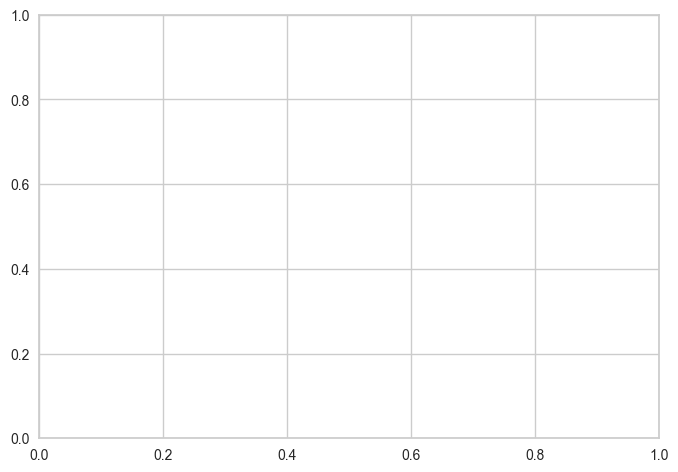

In [6]:
# evaluate_model in Einzelschritten

help(plot_model)
plot_model(bestModell, plot= 'pipeline') # Schematic drawing of the preprocessing pipeline
#plot_model(bestModell, plot= 'residuals_interactive') # Interactive Residual plots
plot_model(bestModell, plot= 'residuals') # Residuals Plot
plot_model(bestModell, plot= 'error') # Prediction Error Plot
#plot_model(bestModell, plot= 'cooks') # Cooks Distance Plot
plot_model(bestModell, plot= 'rfe') # Recursive Feat. Selection
plot_model(bestModell, plot= 'learning') # Learning Curve
plot_model(bestModell, plot= 'vc') # Validation Curve
#plot_model(bestModell, plot= 'manifold') # Manifold Learning
plot_model(bestModell, plot= 'feature') # Feature Importance
plot_model(bestModell, plot= 'feature_all') # Feature Importance (All)
plot_model(bestModell, plot= 'parameter') # Model Hyperparameter
#plot_model(bestModell, plot= 'tree') # Decision Tree

In [ ]:
# SHAP values
# rechenintensiv. Für 166 Variablen > 20 Minuten
interpret_model(bestModell, plot = 'summary') 

In [4]:


#help(interpret_model)
# reason plot for test set observation 1
interpret_model(bestModell, plot = 'reason', observation = 1)


'''
ModuleNotFoundError: 
'shap' is a soft dependency and not included in the pycaret installation. Please run: `pip install shap` to install.
Alternately, you can install this by running `pip install pycaret[analysis]`
'''

TypeError: This function only supports tree based models for binary classification: rf, et, lightgbm, dt.

In [5]:
print(get_config())
print(get_config('pipeline'))
set_config('seed', 42)
print("The new seed is: {}".format(get_config('seed')))

{'memory', 'fold_shuffle_param', 'target_param', 'y_test', 'fold_generator', '_available_plots', 'html_param', 'variables', 'train_transformed', 'X_train', 'test_transformed', 'y_train_transformed', 'dataset_transformed', 'pipeline', 'data', 'train', 'y_test_transformed', 'dataset', 'transform_target_param', 'y_train', 'seed', 'exp_name_log', 'gpu_n_jobs_param', 'test', 'n_jobs_param', 'idx', 'USI', '_ml_usecase', 'fold_groups_param', 'X_train_transformed', 'y_transformed', 'exp_id', 'variable_and_property_keys', 'y', 'log_plots_param', 'is_multiclass', 'X_transformed', 'X_test', 'X_test_transformed', 'gpu_param', 'X', 'logging_param'}
Pipeline(memory=FastMemory(location=C:\Users\noname\AppData\Local\Temp\joblib),
         steps=[('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames()))])
The new seed is: 42


In [7]:
# save model in Pickle Format
save_model(bestModell, 'best_pipeline')
loaded_best_pipeline = load_model('best_pipeline')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\noname\AppData\Local\Temp\joblib),
         steps=[('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('trained_model', GradientBoostingRegressor(random_state=42))])

In [13]:
# predict on new data
new_data = df.head(100).copy().drop('SalePrice', axis = 1)
predictions = predict_model(loaded_best_pipeline, data = new_data)
predictions


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,Railroad_Adjacent,Railroad_Near,Street_Feeder,Street_Aterial,PosFeature_Adjacent,PosFeature_Near,Exterior_AsbShng,Exterior_BrkComm,Exterior_BrkFace,Exterior_CBlock,Exterior_CemntBd,Exterior_HdBoard,Exterior_ImStucc,Exterior_MetalSd,Exterior_Plywood,Exterior_PreCast,Exterior_Stone,Exterior_Stucco,Exterior_VinylSd,Exterior_Wd Sdng,Exterior_WdShing,Street_Pave,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,House Style_1_5Unf,House Style_1Story,House Style_2_5Fin,House Style_2_5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Misc Feature_None,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_None,Sale Condition_Alloca,Sale Condition_Normal,Sale Condition_Partial,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,prediction_label
Housesale,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1 215000 NAmes 1656,20,7,141.000000,31770,0,2,3,4,2,3,6,5,1960,1960,112.0,0,0,2.5,3.0,3.0,3.0,639.0,1.0,0.0,441.0,1080.0,1,1,4.0,1656,0,0,1656,1.0,0.0,1,0,3,1,0,7,7,2,3.0,1960.0,3,2.0,528.0,3.0,3.0,1,210,62,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,209795.764951
2 105000 NAmes 896,20,5,80.000000,11622,0,3,3,4,3,3,5,6,1961,1961,0.0,0,0,2.5,2.5,0.0,2.0,468.0,2.0,144.0,270.0,882.0,2,1,4.0,896,0,0,896,0.0,0.0,1,0,2,1,0,5,7,0,0.0,1961.0,1,1.0,730.0,3.0,3.0,2,140,0,0,0,120,0,2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,122324.659682
3 172000 NAmes 1329,20,7,81.000000,14267,0,2,3,4,2,3,6,6,1958,1958,108.0,0,0,2.5,2.5,0.0,3.5,923.0,1.0,0.0,406.0,1329.0,2,1,4.0,1329,0,0,1329,0.0,0.0,1,1,3,1,1,6,7,0,0.0,1958.0,1,1.0,312.0,3.0,3.0,2,393,36,0,0,0,0,0,12500,0.0,0.0

In [14]:

#help(create_model)
#models()
rf = create_model('rf')
print(rf)
# define tuning grid
grid = {'max_depth' : [None, 2,  6, 10, 12]}
# tune model with custom grid and metric = MAE
tuned_rf, tuner = tune_model(rf, custom_grid = grid, optimize = 'MAE', return_tuner=True)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15210.9112,629170975.0137,25083.2808,0.8627,0.1233,0.0876
1,13465.9267,438651716.8522,20944.0139,0.9333,0.1048,0.0755
2,15619.3251,590358061.9677,24297.2851,0.9175,0.1131,0.0838
3,14022.0381,409950092.6318,20247.2243,0.9169,0.1150,0.0846
4,14281.6962,432771246.2563,20803.1547,0.9279,0.1166,0.0835
5,14724.5290,536062729.9456,23153.0285,0.8942,0.1054,0.0779
6,15889.1822,694017831.7000,26344.2182,0.9125,0.1290,0.0880
7,15864.6412,513593750.9485,22662.6069,0.9221,0.1146,0.0837
8,15913.0284,604419113.6371,24584.9367,0.9118,0.1343,0.0984


RandomForestRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15210.9112,629170975.0137,25083.2808,0.8627,0.1233,0.0876
1,13465.9267,438651716.8522,20944.0139,0.9333,0.1048,0.0755
2,15619.3251,590358061.9677,24297.2851,0.9175,0.1131,0.0838
3,14022.0381,409950092.6318,20247.2243,0.9169,0.1150,0.0846
4,14281.6962,432771246.2563,20803.1547,0.9279,0.1166,0.0835
5,14724.5290,536062729.9456,23153.0285,0.8942,0.1054,0.0779
6,15889.1822,694017831.7000,26344.2182,0.9125,0.1290,0.0880
7,15864.6412,513593750.9485,22662.6069,0.9221,0.1146,0.0837
8,15913.0284,604419113.6371,24584.9367,0.9118,0.1343,0.0984


Fitting 10 folds for each of 5 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [15]:
lb = get_leaderboard()
lb.sort_values(by='MAE', ascending=True)['Model'].iloc[0]

Pipeline(memory=Memory(location=None),
         steps=[('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ['trained_model', LGBMRegressor(n_jobs=-1, random_state=42)]])

In [16]:

print(tuned_rf)
print(tuner)
get_metrics()

RandomForestRegressor(n_jobs=-1, random_state=42)
RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(memory=Memory(location=None),
                                      steps=[('clean_column_names',
                                              TransformerWrapper(transformer=CleanColumnNames())),
                                             ('actual_estimator',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'actual_estimator__max_depth': [None, 2,
                                                                        6, 10,
                                                                        12]},
                   random_state=42, refit=False,
                   scoring='neg_mean_absolute_error', verbose=1)


,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Custom
ID,,,,,,,,
mae,MAE,MAE,<function mean_absolute_error at 0x000001593C7...,neg_mean_absolute_error,pred,{},False,False
mse,MSE,MSE,<function mean_squared_error at 0x000001593C73...,neg_mean_squared_error,pred,{},False,False
rmse,RMSE,RMSE,<function mean_squared_error at 0x000001593C73...,neg_root_mean_squared_error,pred,{'squared': False},False,False
r2,R2,R2,<function r2_score at 0x000001593C7378B0>,r2,pred,{},True,False
rmsle,RMSLE,RMSLE,<function RMSLEMetricContainer.__init__.<local...,"make_scorer(root_mean_squared_log_error, great...",pred,{},False,False
mape,MAPE,MAPE,<function MAPEMetricContainer.__init__.<locals...,"make_scorer(mean_absolute_percentage_error, gr...",pred,{},False,False
